# Homework 2 Facial Keypoint Detection

### Load Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
if not os.path.exists('facial_keypoints.npz'):
  !wget -O facial_keypoints.npz "https://www.dropbox.com/scl/fi/27qggijmythfjg04s24xq/facial_keypoints.npz?rlkey=h91gwodhrfuz8hrc7ux9qnq7s&dl=1"

In [3]:
data = np.load('facial_keypoints.npz')
images = data['images']
keypoints = data['keypoints']

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Inspect data

In [5]:
images.shape, images.dtype, images.min(), images.max()

((7049, 1, 96, 96), dtype('int64'), np.int64(0), np.int64(255))

In [6]:
keypoints.shape, keypoints.dtype, np.nanmin(keypoints), np.nanmax(keypoints)

((7049, 30), dtype('float32'), np.float32(0.686592), np.float32(95.935646))

In [7]:
keypoints[0]

array([66.03356 , 39.002274, 30.227007, 36.421677, 59.582077, 39.647423,
       73.13035 , 39.969997, 36.35657 , 37.3894  , 23.452871, 37.3894  ,
       56.953262, 29.033648, 80.22713 , 32.228138, 40.227608, 29.002321,
       16.356379, 29.64747 , 44.42057 , 57.066803, 61.19531 , 79.97017 ,
       28.614496, 77.38899 , 43.312603, 72.935455, 43.130707, 84.48577 ],
      dtype=float32)

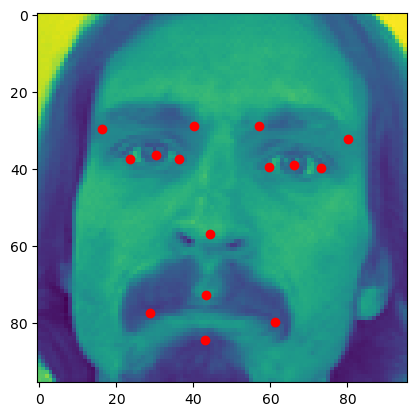

In [8]:
def plot(image=images[0][0], keypoints=keypoints[0]):
    plt.imshow(image)
    for i, point in enumerate(keypoints):
        if i % 2 == 0:
            x = point
        elif x != np.nan and point != np.nan:
           plt.plot(x, point, 'ro')
plot()

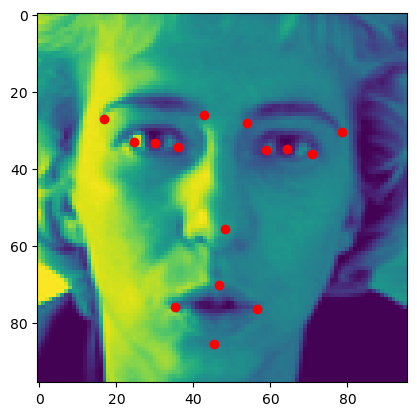

In [9]:
plot(images[1][0], keypoints[1])

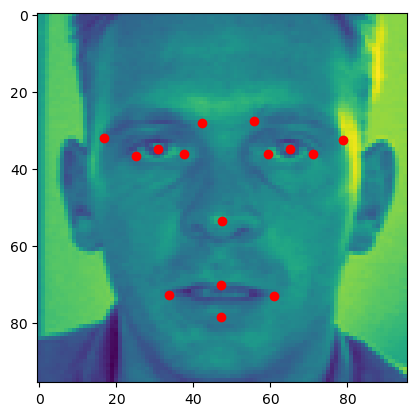

In [10]:
plot(images[2][0], keypoints[2])

### Preprocess and split data

In [11]:
# HYPERPARAMETERS
test_size = 0.10  # 90/10 train/test split
batch_size = 64
lr = 0.01
momentum = 0.9
epochs = 100
model_path = 'models'
train_path = 'runs'
dtype = torch.float32

In [12]:
# preprocess the data as appropriate
# be careful to avoid missing values, sklearn preprocessing classes avoids NaN values
X = images / 255.0
scaler = StandardScaler()
y = scaler.fit_transform(keypoints)

# prepare train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

### Prepare Dataset and DataLoader

In [13]:
X_train_tensor = torch.as_tensor(X_train, device=device, dtype=dtype)
y_train_tensor = torch.as_tensor(y_train, device=device, dtype=dtype)
X_test_tensor = torch.as_tensor(X_test, device=device, dtype=dtype)
y_test_tensor = torch.as_tensor(y_test, device=device, dtype=dtype)

train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=batch_size,
    shuffle=True,
)

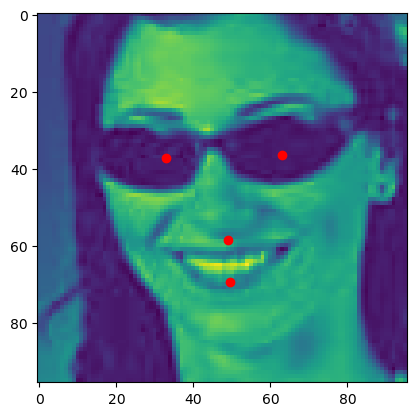

In [14]:
plot(X_test_tensor[0][0].cpu(), scaler.inverse_transform(y_test_tensor.cpu())[0])

### Create a CNN

In [15]:
def train_model(
    model: nn.Module, 
    opt: torch.optim.Optimizer,
    dataloader: DataLoader,
    criterion: nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 100,
):
    model.train()  # set model to training mode
    
    for epoch in range(epochs):
        avg_loss = 0
        for X_batch, y_batch in dataloader:
            opt.zero_grad()
            z = model(X_batch)
            loss = criterion(z, y_batch)
            loss.backward()
            opt.step()
            avg_loss += loss.item()
        print(f'loss: {avg_loss / dataloader.batch_size}')

In [16]:
# Define custom loss function
class MaskedMAELoss(nn.Module):
    def __init__(self):
        super(MaskedMAELoss, self).__init__()

    def forward(self, z, y):
        valid_elements = (~torch.isnan(y)).float().sum()

        if valid_elements == 0:  # Prevent division by zero
            return torch.tensor(0.0, device=z.device, requires_grad=True)

        diff = torch.abs(z - y)
        # diff = torch.pow(z - y, 2)  # causes nans for some reason?
        return torch.nansum(diff) / valid_elements

In [ ]:
# making sure loss function works as intended
y = y_test_tensor
z = torch.ones(y_test_tensor.shape).to(device)
print(MaskedMAELoss()(z, y).item())
z = torch.Tensor([np.nan] * 30).to(device)
print(MaskedMAELoss()(z, y).item())

In [18]:
class Vgg(nn.Module):
    def __init__(self, in_channels=1, out_dim=30, im_width=96, device=torch.device("cpu")):
        super(Vgg, self).__init__()
        k, p, mode = 3, 1, "replicate"
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=k, padding=p, padding_mode=mode)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=k, padding=p, padding_mode=mode)           
        self.conv3 = nn.Conv2d(32, 64, kernel_size=k, padding=p, padding_mode=mode)       
        self.conv4 = nn.Conv2d(64, 64, kernel_size=k, padding=p, padding_mode=mode)       
        self.conv5 = nn.Conv2d(64, 128, kernel_size=k, padding=p, padding_mode=mode)       
        self.conv6 = nn.Conv2d(128, 128, kernel_size=k, padding=p, padding_mode=mode)
        self.pool = nn.MaxPool2d(2, 2)
        self.activate = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(128 * int(im_width / 8)**2, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.out = nn.Linear(2048, out_dim)

        # move the model
        self.device = device
        device = self.to(self.device)

    def forward(self, x):
                                          # 1, 96, 96
        x = self.activate(self.conv1(x))  # 32, 96, 96
        x = self.activate(self.conv2(x))  # 32, 96, 96
        x = self.pool(x)                  # 32, 48, 48
        x = self.activate(self.conv3(x))  # 64, 48, 48
        x = self.activate(self.conv4(x))  # 64, 48, 48
        x = self.pool(x)                  # 64, 24, 24
        x = self.activate(self.conv5(x))  # 128, 24, 24
        x = self.activate(self.conv6(x))  # 128, 24, 24
        x = self.pool(x)                  # 128, 12, 12
        x = self.flatten(x)               # 128 * 12 * 12
        x = self.activate(self.fc1(x))    # 4096
        x = self.activate(self.fc2(x))    # 2048
        return self.out(x)                # 30

vgg = Vgg(device=device)
opt = torch.optim.SGD(vgg.parameters(), lr=lr, momentum=momentum)

In [19]:
train_model(vgg, opt, train_loader, criterion=MaskedMAELoss(), epochs=epochs)

loss: 1.0898690838366747
loss: 1.0916672386229038
loss: 1.0880154445767403
loss: 1.0886728540062904
loss: 1.091320258565247
loss: 1.088021588511765
loss: 1.0868754675611854
loss: 1.0883734840899706
loss: 1.0876720300875604
loss: 1.0954828606918454
loss: 1.0886820247396827
loss: 1.087673527188599
loss: 1.0813038321211934
loss: 1.0540121160447598
loss: 1.0176301077008247
loss: 0.9737841519527137
loss: 0.9355303640477359
loss: 0.8949471139349043
loss: 0.8502486064098775
loss: 0.7820854620076716
loss: 0.7453612587414682
loss: 0.679142642300576
loss: 0.6388686862774193
loss: 0.599499843083322
loss: 0.569619934540242
loss: 0.5392818590626121
loss: 0.5043417550623417
loss: 0.4769718067254871
loss: 0.44945281301625073
loss: 0.4320681719109416
loss: 0.40121665550395846
loss: 0.3809283687733114
loss: 0.37655930896289647
loss: 0.3538092484232038
loss: 0.33329198881983757
loss: 0.3226654385216534
loss: 0.3118723016232252
loss: 0.29742599884048104
loss: 0.2859719607513398
loss: 0.2736048751976341
l

In [20]:
vgg(X_test_tensor)[0]

tensor([-0.4579, -0.2167,  0.2194,  0.0198, -0.8969,  0.2089,  0.0867, -0.1403,
         0.2515,  0.4427,  0.0365,  0.3784, -1.1312,  0.4313,  0.0266, -0.2771,
        -0.3053,  0.7470,  0.2078,  0.2378, -0.3789, -0.0954,  0.5682, -0.7743,
         0.4336, -0.6082,  0.1751, -0.1282,  0.0810, -1.2214], device='cuda:0',
       grad_fn=<SelectBackward0>)

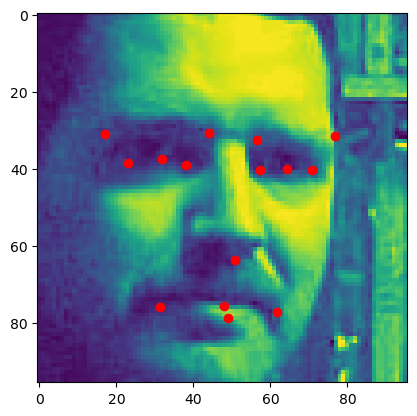

In [29]:
plot(X_test_tensor[1][0].cpu(), 
     scaler.inverse_transform(vgg(X_test_tensor).detach().cpu())[1])

In [31]:
MaskedMAELoss()(vgg(X_test_tensor), y_test_tensor)

tensor(0.3249, device='cuda:0', grad_fn=<DivBackward0>)

# It works! 
Loss on the test set is a little high, showing overfitting on the training data. But, results seem promising for such a difficult task, and the test image shows human interpretable results.